In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Embedding
from sklearn.utils import shuffle
from numpy.core.fromnumeric import mean
import timeit
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **READ DATA**

In [3]:
def load_datasets(path, num):
    f = open(path)
    temp_data = []
    temp_label = []
    number = []
    label = -1
    count = 0

    while True:
        line = f.readline()
        temp = np.array(line.split(), dtype=float)
        if temp.size != 0: 
            number.append(temp)
        else:
            if np.array(number).size != 0:
                if count % num == 0:
                    label +=1
                temp_data.append(np.array(number, dtype=float))
                temp_label.append(label)
                count += 1
            number.clear()

        if not line:
            temp_data = np.array(temp_data)
            temp_label = np.array(temp_label)
            break
    return(temp_data, temp_label)

In [4]:
path_train = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data/Train_Arabic_Digit.txt'
path_test = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/Data/Test_Arabic_Digit.txt'
train_data, train_label = load_datasets(path_train, 660)
test_data, test_label = load_datasets(path_test, 220)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


# **BATCH GENERATOR**

In [5]:
def batch_gen(X,y,batch_number):
    X_batches = []
    X_split = np.split(X, batch_number)
    y_batches = np.split(y, batch_number)
    for i in X_split:
        X_batches.append(tf.keras.preprocessing.sequence.pad_sequences(i, padding="post", dtype=float)) #padding
    return X_batches, y_batches

In [6]:
#shuffle dataset
X_train, y_train = shuffle(train_data, train_label)
#create batch 
batch_length = 100
batch_num = int(len(X_train)/batch_length)
X, y = batch_gen(X_train, y_train, batch_num)

In [7]:
X_test, y_test = shuffle(test_data, test_label)
batch_num_test = int(len(X_test)/batch_length)
Xtest, ytest = batch_gen(X_train, y_train, batch_num_test)

# **CREATE MODEL**

In [6]:
model_lstm = Sequential()

model_lstm.add(LSTM(units=512, stateful=False, input_shape=(None, 13),dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation='relu'))
model_lstm.add(Dropout(0.3))
#model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dense(10, activation = 'softmax'))
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1077248   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 1,211,146
Trainable params: 1,211,146
Non-trainable params: 0
_________________________________________________________________


In [7]:
model_lstm.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer='Adam',
    metrics=['accuracy']
)

**run model**

In [17]:
rep = []
for i in range(batch_num):
	rep.append(model_lstm.fit(
    X[i],
    y[i],
    validation_split=0.1,
    epochs = 10
))
	model_lstm.reset_states()

Epoch 1/10
3/3 [==============================] - 4s 540ms/step - loss: 2.2793 - accuracy: 0.1111 - val_loss: 2.4541 - val_accuracy: 0.2000
Epoch 2/10
3/3 [==============================] - 1s 346ms/step - loss: 2.1915 - accuracy: 0.1667 - val_loss: 2.4288 - val_accuracy: 0.1000
Epoch 3/10
3/3 [==============================] - 1s 344ms/step - loss: 2.0930 - accuracy: 0.2333 - val_loss: 2.5304 - val_accuracy: 0.0000e+00
Epoch 4/10
3/3 [==============================] - 1s 343ms/step - loss: 2.0052 - accuracy: 0.3111 - val_loss: 2.2320 - val_accuracy: 0.3000
Epoch 5/10
3/3 [==============================] - 1s 343ms/step - loss: 1.8003 - accuracy: 0.3667 - val_loss: 2.4121 - val_accuracy: 0.2000
Epoch 6/10
3/3 [==============================] - 1s 342ms/step - loss: 1.6718 - accuracy: 0.3556 - val_loss: 1.9747 - val_accuracy: 0.3000
Epoch 7/10
3/3 [==============================] - 1s 358ms/step - loss: 1.5577 - accuracy: 0.4333 - val_loss: 2.3235 - val_accuracy: 0.5000
Epoch 8/10
3/3 [

In [18]:
res = []
for i in range(batch_num_test):
	res.append(model_lstm.evaluate(
    Xtest[i],
    ytest[i],
))

10/10 [==============================] - 0s 42ms/step - loss: 0.0968 - accuracy: 0.9733


# **RESULT**

In [19]:
res = np.array(res)
loss = res[:,0]
acc = res[:,1]
print('loss = ', mean(loss))
print('accuracy = ', mean(acc))

loss =  0.16222093559124254
accuracy =  0.9539393945173784


In [ ]:
print('training epoch = ', 10 * batch_num)
print('batch size = ',batch_length)

training epoch =  660
batch size =  100


In [ ]:
acc_rep = rep[0].history['accuracy']
for i in range (len(rep)-1):
    acc_rep += rep[i+1].history['accuracy']
Vacc_rep = rep[0].history['val_accuracy']
for i in range (len(rep)-1):
    Vacc_rep += rep[i+1].history['val_accuracy']

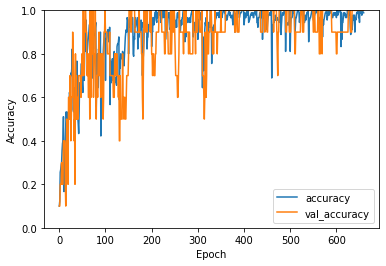

In [ ]:
plt.plot(acc_rep, label='accuracy')
plt.plot(Vacc_rep, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [ ]:
loss_rep = rep[0].history['loss']
for i in range (len(rep)-1):
    loss_rep += rep[i+1].history['loss']
Vloss_rep = rep[0].history['val_loss']
for i in range (len(rep)-1):
    Vloss_rep += rep[i+1].history['val_loss']

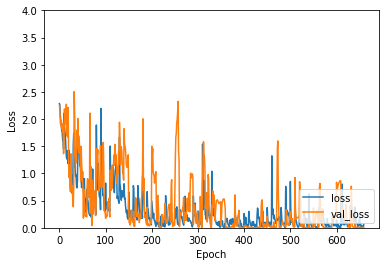

In [ ]:
plt.plot(loss_rep, label='loss')
plt.plot(Vloss_rep, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')

# **TRY FOR DEFFERENT BATCH AND EPOCH**

**1/5**

In [ ]:
#shuffle dataset
X_train, y_train = shuffle(train_data, train_label)
#create batch 
batch_length = 100
batch_num = int(len(X_train)/batch_length)
X, y = batch_gen(X_train, y_train, batch_num)

X_test, y_test = shuffle(test_data, test_label)
batch_num_test = int(len(X_test)/batch_length)
Xtest, ytest = batch_gen(X_train, y_train, batch_num_test)

In [ ]:
print('training epoch = ', 5 * batch_num)
print('batch size = ',batch_length)

training epoch =  330
batch size =  100


In [ ]:
start = timeit.default_timer()
rep = []
for i in range(batch_num):
	rep.append(model_lstm.fit(
    X[i],
    y[i],
    validation_split=0.1,
    epochs = 5
))
	model_lstm.reset_states()

stop = timeit.default_timer()

Epoch 1/5
3/3 [==============================] - 4s 560ms/step - loss: 2.2930 - accuracy: 0.1333 - val_loss: 2.3201 - val_accuracy: 0.0000e+00
Epoch 2/5
3/3 [==============================] - 1s 360ms/step - loss: 2.1730 - accuracy: 0.2000 - val_loss: 2.2384 - val_accuracy: 0.2000
Epoch 3/5
3/3 [==============================] - 1s 368ms/step - loss: 2.1544 - accuracy: 0.1778 - val_loss: 2.4236 - val_accuracy: 0.0000e+00
Epoch 4/5
3/3 [==============================] - 1s 358ms/step - loss: 1.9598 - accuracy: 0.3111 - val_loss: 2.3998 - val_accuracy: 0.0000e+00
Epoch 5/5
3/3 [==============================] - 1s 354ms/step - loss: 2.0956 - accuracy: 0.2444 - val_loss: 2.2779 - val_accuracy: 0.1000
Epoch 1/5
3/3 [==============================] - 3s 546ms/step - loss: 2.1523 - accuracy: 0.2111 - val_loss: 2.0614 - val_accuracy: 0.1000
Epoch 2/5
3/3 [==============================] - 1s 354ms/step - loss: 1.9465 - accuracy: 0.2889 - val_loss: 1.9011 - val_accuracy: 0.2000
Epoch 3/5
3/3 [

In [ ]:
res = []
for i in range(batch_num_test):
	res.append(model_lstm.evaluate(
    Xtest[i],
    ytest[i],
))

10/10 [==============================] - 1s 61ms/step - loss: 0.0537 - accuracy: 0.9833


In [ ]:
res = np.array(res)
loss = res[:,0]
acc = res[:,1]
print('loss = ', mean(loss))
print('accuracy = ', mean(acc))
print('Time = ', stop - start) 

loss =  0.17265707525339993
accuracy =  0.9536363563754342
Time =  557.9490486450002


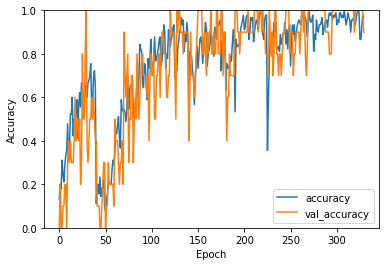

In [ ]:
acc_rep = rep[0].history['accuracy']
for i in range (len(rep)-1):
    acc_rep += rep[i+1].history['accuracy']
Vacc_rep = rep[0].history['val_accuracy']
for i in range (len(rep)-1):
    Vacc_rep += rep[i+1].history['val_accuracy']
plt.plot(acc_rep, label='accuracy')
plt.plot(Vacc_rep, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

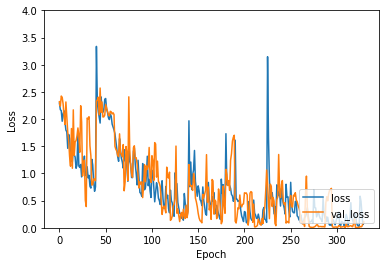

In [ ]:
loss_rep = rep[0].history['loss']
for i in range (len(rep)-1):
    loss_rep += rep[i+1].history['loss']
Vloss_rep = rep[0].history['val_loss']
for i in range (len(rep)-1):
    Vloss_rep += rep[i+1].history['val_loss']
plt.plot(loss_rep, label='loss')
plt.plot(Vloss_rep, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')

**2/5**

In [ ]:
#shuffle dataset
X_train, y_train = shuffle(train_data, train_label)
#create batch 
batch_length = 200
batch_num = int(len(X_train)/batch_length)
X, y = batch_gen(X_train, y_train, batch_num)

X_test, y_test = shuffle(test_data, test_label)
batch_num_test = int(len(X_test)/batch_length)
Xtest, ytest = batch_gen(X_train, y_train, batch_num_test)

In [ ]:
print('training epoch = ', 10 * batch_num)
print('batch size = ',batch_length)

training epoch =  330
batch size =  200


In [ ]:
start = timeit.default_timer()
rep = []
for i in range(batch_num):
	rep.append(model_lstm.fit(
    X[i],
    y[i],
    validation_split=0.1,
    epochs = 10
))
	model_lstm.reset_states()

stop = timeit.default_timer()

Epoch 1/10
6/6 [==============================] - 5s 464ms/step - loss: 2.2929 - accuracy: 0.1056 - val_loss: 2.1266 - val_accuracy: 0.2500
Epoch 2/10
6/6 [==============================] - 2s 339ms/step - loss: 2.1506 - accuracy: 0.2611 - val_loss: 1.9883 - val_accuracy: 0.3000
Epoch 3/10
6/6 [==============================] - 2s 337ms/step - loss: 2.1352 - accuracy: 0.2333 - val_loss: 1.8812 - val_accuracy: 0.3500
Epoch 4/10
6/6 [==============================] - 2s 361ms/step - loss: 2.0112 - accuracy: 0.2833 - val_loss: 1.7667 - val_accuracy: 0.4000
Epoch 5/10
6/6 [==============================] - 2s 333ms/step - loss: 1.7686 - accuracy: 0.3444 - val_loss: 1.6385 - val_accuracy: 0.3000
Epoch 6/10
6/6 [==============================] - 2s 353ms/step - loss: 1.6538 - accuracy: 0.3889 - val_loss: 1.8623 - val_accuracy: 0.3000
Epoch 7/10
6/6 [==============================] - 2s 336ms/step - loss: 1.5863 - accuracy: 0.4444 - val_loss: 1.3869 - val_accuracy: 0.4500
Epoch 8/10
6/6 [====

In [ ]:
res = []
for i in range(batch_num_test):
	res.append(model_lstm.evaluate(
    Xtest[i],
    ytest[i],
))

19/19 [==============================] - 1s 71ms/step - loss: 0.2954 - accuracy: 0.9183


In [ ]:
res = np.array(res)
loss = res[:,0]
acc = res[:,1]
print('loss = ', mean(loss))
print('accuracy = ', mean(acc))
print('Time = ', stop - start) 

loss =  0.25582612305879593
accuracy =  0.9381818175315857
Time =  1118.4091537139998


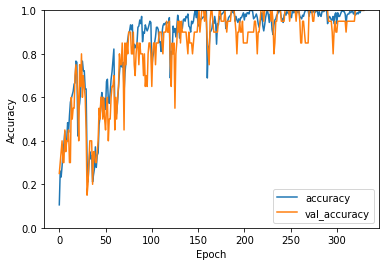

In [ ]:
acc_rep = rep[0].history['accuracy']
for i in range (len(rep)-1):
    acc_rep += rep[i+1].history['accuracy']
Vacc_rep = rep[0].history['val_accuracy']
for i in range (len(rep)-1):
    Vacc_rep += rep[i+1].history['val_accuracy']
plt.plot(acc_rep, label='accuracy')
plt.plot(Vacc_rep, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

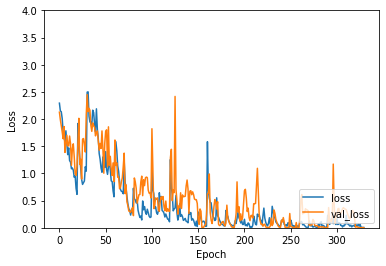

In [ ]:
loss_rep = rep[0].history['loss']
for i in range (len(rep)-1):
    loss_rep += rep[i+1].history['loss']
Vloss_rep = rep[0].history['val_loss']
for i in range (len(rep)-1):
    Vloss_rep += rep[i+1].history['val_loss']
plt.plot(loss_rep, label='loss')
plt.plot(Vloss_rep, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')

**3/5**

In [8]:
#shuffle dataset
X_train, y_train = shuffle(train_data, train_label)
#create batch 
batch_length = 200
batch_num = int(len(X_train)/batch_length)
X, y = batch_gen(X_train, y_train, batch_num)

X_test, y_test = shuffle(test_data, test_label)
batch_num_test = int(len(X_test)/batch_length)
Xtest, ytest = batch_gen(X_train, y_train, batch_num_test)

In [9]:
print('training epoch = ', 5 * batch_num)
print('batch size = ',batch_length)

training epoch =  165
batch size =  200


In [10]:
start = timeit.default_timer()
rep = []
for i in range(batch_num):
	rep.append(model_lstm.fit(
    X[i],
    y[i],
    validation_split=0.1,
    epochs = 5
))
	model_lstm.reset_states()

stop = timeit.default_timer()

Epoch 1/5
6/6 [==============================] - 7s 500ms/step - loss: 2.3096 - accuracy: 0.1500 - val_loss: 2.2932 - val_accuracy: 0.2500
Epoch 2/5
6/6 [==============================] - 2s 372ms/step - loss: 2.2585 - accuracy: 0.2056 - val_loss: 2.2129 - val_accuracy: 0.2000
Epoch 3/5
6/6 [==============================] - 2s 390ms/step - loss: 2.1988 - accuracy: 0.2000 - val_loss: 2.1684 - val_accuracy: 0.1500
Epoch 4/5
6/6 [==============================] - 2s 371ms/step - loss: 2.1033 - accuracy: 0.2556 - val_loss: 2.1044 - val_accuracy: 0.2000
Epoch 5/5
6/6 [==============================] - 2s 366ms/step - loss: 1.9718 - accuracy: 0.2333 - val_loss: 2.0400 - val_accuracy: 0.1500
Epoch 1/5
6/6 [==============================] - 4s 397ms/step - loss: 1.9007 - accuracy: 0.2778 - val_loss: 1.8669 - val_accuracy: 0.3500
Epoch 2/5
6/6 [==============================] - 2s 303ms/step - loss: 1.8311 - accuracy: 0.2389 - val_loss: 1.8583 - val_accuracy: 0.3500
Epoch 3/5
6/6 [============

In [11]:
res = []
for i in range(batch_num_test):
	res.append(model_lstm.evaluate(
    Xtest[i],
    ytest[i],
))

19/19 [==============================] - 1s 45ms/step - loss: 0.1961 - accuracy: 0.9533


In [12]:
res = np.array(res)
loss = res[:,0]
acc = res[:,1]
print('loss = ', mean(loss))
print('accuracy = ', mean(acc))
print('Time = ', stop - start) 

loss =  0.3430905436927622
accuracy =  0.909090903672305
Time =  389.911431517


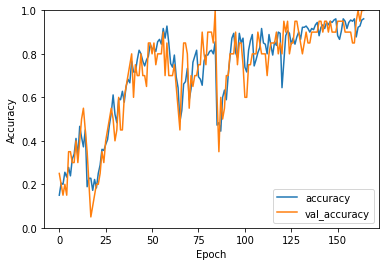

In [13]:
acc_rep = rep[0].history['accuracy']
for i in range (len(rep)-1):
    acc_rep += rep[i+1].history['accuracy']
Vacc_rep = rep[0].history['val_accuracy']
for i in range (len(rep)-1):
    Vacc_rep += rep[i+1].history['val_accuracy']
plt.plot(acc_rep, label='accuracy')
plt.plot(Vacc_rep, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

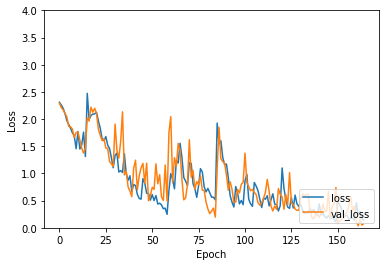

In [14]:
loss_rep = rep[0].history['loss']
for i in range (len(rep)-1):
    loss_rep += rep[i+1].history['loss']
Vloss_rep = rep[0].history['val_loss']
for i in range (len(rep)-1):
    Vloss_rep += rep[i+1].history['val_loss']
plt.plot(loss_rep, label='loss')
plt.plot(Vloss_rep, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')

**4/5**

In [ ]:
#shuffle dataset
X_train, y_train = shuffle(train_data, train_label)
#create batch 
batch_length = 550
batch_num = int(len(X_train)/batch_length)
X, y = batch_gen(X_train, y_train, batch_num)

X_test, y_test = shuffle(test_data, test_label)
batch_num_test = int(len(X_test)/batch_length)
Xtest, ytest = batch_gen(X_train, y_train, batch_num_test)

In [ ]:
print('training epoch = ', 5 * batch_num)
print('batch size = ',batch_length)

training epoch =  60
batch size =  550


In [ ]:
start = timeit.default_timer()
rep = []
for i in range(batch_num):
	rep.append(model_lstm.fit(
    X[i],
    y[i],
    validation_split=0.1,
    epochs = 5
))
	model_lstm.reset_states()

stop = timeit.default_timer()

Epoch 1/5
16/16 [==============================] - 10s 427ms/step - loss: 2.2978 - accuracy: 0.0909 - val_loss: 2.2876 - val_accuracy: 0.1273
Epoch 2/5
16/16 [==============================] - 6s 389ms/step - loss: 2.2745 - accuracy: 0.1374 - val_loss: 2.1401 - val_accuracy: 0.2727
Epoch 3/5
16/16 [==============================] - 6s 396ms/step - loss: 2.1234 - accuracy: 0.1859 - val_loss: 2.0867 - val_accuracy: 0.1273
Epoch 4/5
16/16 [==============================] - 6s 395ms/step - loss: 2.0386 - accuracy: 0.2303 - val_loss: 1.8950 - val_accuracy: 0.2545
Epoch 5/5
16/16 [==============================] - 6s 395ms/step - loss: 1.9228 - accuracy: 0.2707 - val_loss: 1.7464 - val_accuracy: 0.3455
Epoch 1/5
16/16 [==============================] - 8s 427ms/step - loss: 1.7047 - accuracy: 0.2869 - val_loss: 1.5644 - val_accuracy: 0.3636
Epoch 2/5
16/16 [==============================] - 6s 362ms/step - loss: 1.7505 - accuracy: 0.3535 - val_loss: 1.6652 - val_accuracy: 0.4000
Epoch 3/5
16

In [ ]:
res = []
for i in range(batch_num_test):
	res.append(model_lstm.evaluate(
    Xtest[i],
    ytest[i],
))

52/52 [==============================] - 4s 75ms/step - loss: 1.4112 - accuracy: 0.5024


In [ ]:
res = np.array(res)
loss = res[:,0]
acc = res[:,1]
print('loss = ', mean(loss))
print('accuracy = ', mean(acc))
print('Time = ', stop - start) 

loss =  1.4133059084415436
accuracy =  0.5104545429348946
Time =  441.4009706079996


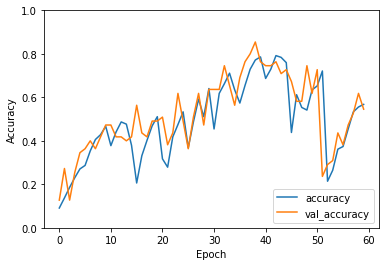

In [ ]:
acc_rep = rep[0].history['accuracy']
for i in range (len(rep)-1):
    acc_rep += rep[i+1].history['accuracy']
Vacc_rep = rep[0].history['val_accuracy']
for i in range (len(rep)-1):
    Vacc_rep += rep[i+1].history['val_accuracy']
plt.plot(acc_rep, label='accuracy')
plt.plot(Vacc_rep, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

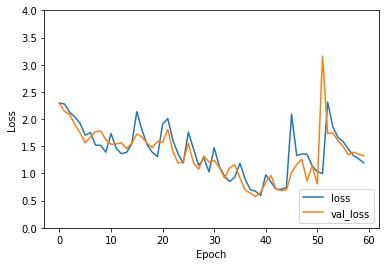

In [ ]:
loss_rep = rep[0].history['loss']
for i in range (len(rep)-1):
    loss_rep += rep[i+1].history['loss']
Vloss_rep = rep[0].history['val_loss']
for i in range (len(rep)-1):
    Vloss_rep += rep[i+1].history['val_loss']
plt.plot(loss_rep, label='loss')
plt.plot(Vloss_rep, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')

**5/5**

In [ ]:
#shuffle dataset
X_train, y_train = shuffle(train_data, train_label)
#create batch 
batch_length = 550
batch_num = int(len(X_train)/batch_length)
X, y = batch_gen(X_train, y_train, batch_num)

X_test, y_test = shuffle(test_data, test_label)
batch_num_test = int(len(X_test)/batch_length)
Xtest, ytest = batch_gen(X_train, y_train, batch_num_test)

In [ ]:
print('training epoch = ', 20 * batch_num)
print('batch size = ',batch_length)

training epoch =  240
batch size =  550


In [ ]:
start = timeit.default_timer()
rep = []
for i in range(batch_num):
	rep.append(model_lstm.fit(
    X[i],
    y[i],
    validation_split=0.1,
    epochs = 20
))
	model_lstm.reset_states()

stop = timeit.default_timer()

Epoch 1/20
16/16 [==============================] - 9s 368ms/step - loss: 2.2530 - accuracy: 0.1515 - val_loss: 2.2803 - val_accuracy: 0.2182
Epoch 2/20
16/16 [==============================] - 5s 337ms/step - loss: 2.0030 - accuracy: 0.2667 - val_loss: 2.0176 - val_accuracy: 0.2000
Epoch 3/20
16/16 [==============================] - 5s 326ms/step - loss: 1.6350 - accuracy: 0.4242 - val_loss: 1.3746 - val_accuracy: 0.4182
Epoch 4/20
16/16 [==============================] - 5s 335ms/step - loss: 1.2699 - accuracy: 0.5394 - val_loss: 0.8779 - val_accuracy: 0.6364
Epoch 5/20
16/16 [==============================] - 5s 341ms/step - loss: 1.1757 - accuracy: 0.5778 - val_loss: 1.0104 - val_accuracy: 0.7273
Epoch 6/20
16/16 [==============================] - 5s 338ms/step - loss: 1.2438 - accuracy: 0.5899 - val_loss: 1.2106 - val_accuracy: 0.6000
Epoch 7/20
16/16 [==============================] - 5s 343ms/step - loss: 0.9751 - accuracy: 0.6566 - val_loss: 1.1621 - val_accuracy: 0.6364
Epoch 

In [ ]:
res = []
for i in range(batch_num_test):
	res.append(model_lstm.evaluate(
    Xtest[i],
    ytest[i],
))

52/52 [==============================] - 4s 71ms/step - loss: 0.1263 - accuracy: 0.9667


In [ ]:
res = np.array(res)
loss = res[:,0]
acc = res[:,1]
print('loss = ', mean(loss))
print('accuracy = ', mean(acc))
print('Time = ', stop - start) 

loss =  0.14563253335654736
accuracy =  0.9587878733873367
Time =  1745.703247501


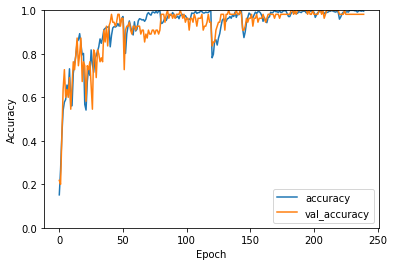

In [ ]:
acc_rep = rep[0].history['accuracy']
for i in range (len(rep)-1):
    acc_rep += rep[i+1].history['accuracy']
Vacc_rep = rep[0].history['val_accuracy']
for i in range (len(rep)-1):
    Vacc_rep += rep[i+1].history['val_accuracy']
plt.plot(acc_rep, label='accuracy')
plt.plot(Vacc_rep, label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

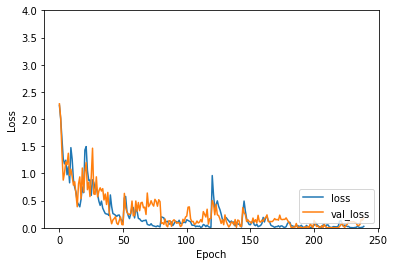

In [ ]:
loss_rep = rep[0].history['loss']
for i in range (len(rep)-1):
    loss_rep += rep[i+1].history['loss']
Vloss_rep = rep[0].history['val_loss']
for i in range (len(rep)-1):
    Vloss_rep += rep[i+1].history['val_loss']
plt.plot(loss_rep, label='loss')
plt.plot(Vloss_rep, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 4])
plt.legend(loc='lower right')